In [1]:
import datetime
import tarfile
import json
import bz2
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Filtering tweets from monthly .tar files

In [2]:
#keywords to filter the tweets
keywords=['gmo','gmos','gm food','gm foods','transgenic', 'transgenics','genetically-modified','genetically modified']

# initializing array which will hold the filtered tweets
filteredTweets=[]


# opening the tar file
with tarfile.open('data/TweetDS.tar', 'r') as tar:
    
    # iterating through all files and directories
    for member in tar.getmembers():
        
        #skipping directories
        if member.isdir():
            continue
        
        #looking for the target files json.bz2
        if member.name.endswith('.json.bz2'):
            
            # extracting each file
            file = tar.extractfile(member)
         
            #reading in and decompressing the file
            noBz2 = bz2.decompress(file.read()).decode('utf-8')
            
            # handling each tweet to find the match
            for line in noBz2.splitlines():
                
                #each line is one tweet in json format, therefore loading line by line
                tweet = json.loads(line)

                # making sure the tweet has the fields 'text' and 'created_at'. If not they'll be skipped
                if 'text' not in tweet or 'created_at' not in tweet or tweet['user']['lang'] != 'en':
                    continue

                # Skipping retweets
                if tweet['text'].startswith('RT') and tweet.get('retweeted_status') is not None:
                    continue
                
                # storing fields if present
                tweetTxt = tweet['text']
                created_at = tweet['created_at']

                # Searching matches in text, splitting by words, lower case like keywords
                if any(keyword in tweetTxt.lower().split() for keyword in keywords):                
                    # Add the matching tweet to the list
                    filteredTweets.append({
                        'text': tweetTxt,
                        'created_at': created_at
                    })
                    

                    
#writting the fields from matching tweets to a json output file
with open('myTweets.json', 'w') as output:
    json.dump(filteredTweets, output)

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, desc, min, max, date_format, expr, hour, year, month, dayofweek, count
from pyspark.sql import functions as F #module that includes a variety of functions like to extract features

In [4]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### Loading json data files to pyspark

In [5]:
#funtion to parce the date string
def parseDate(date_str):
    return datetime.datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y') # strptime() method creates a datetime object from a string

#user-defined function so that it can be used with spark. Returns timestamp object from the string provided 
parse_date_udf= udf(parseDate, TimestampType())

#reading in all the monthly json files
tweetsDf= spark.read.json('hdfs://localhost:9000/user1/tweet*.json')

# applying udf to column
tweetsDf= tweetsDf.withColumn('created_at', parse_date_udf(tweetsDf['created_at']))

#sorting by timestamp
tweetsDf= tweetsDf.orderBy('created_at')

tweetsDf.printSchema();tweetsDf.show()

root
 |-- created_at: timestamp (nullable = true)
 |-- text: string (nullable = true)



+-------------------+--------------------+
|         created_at|                text|
+-------------------+--------------------+
|2012-01-02 20:09:42|USDA has settled ...|
|2012-01-03 02:41:36|Sounds INSANE. GM...|
|2012-01-03 06:57:08|Petition: Tell th...|
|2012-01-03 12:30:19|Mandatory GMO foo...|
|2012-01-03 14:11:44|http://t.co/TI9oL...|
|2012-01-03 16:10:27|Want to learn mor...|
|2012-01-03 17:53:55|Safety assessment...|
|2012-01-03 18:30:38|GMO labeling effo...|
|2012-01-03 20:04:57|Leaked: US to Sta...|
|2012-01-04 00:22:12|Leaked: US to Sta...|
|2012-01-04 13:37:46|@IPIMCIMCIM  GMOs...|
|2012-01-05 02:42:31|@Kaybaebaeeee gmo...|
|2012-01-05 06:10:28|Apel ws. legislac...|
|2012-01-05 09:36:54|Woman files class...|
|2012-01-05 16:14:15|Leaked: US to Sta...|
|2012-01-05 17:42:20|@harjxo GMO twidd...|
|2012-01-05 19:42:18|@songbirdtiff Yup...|
|2012-01-05 21:07:46|Label GMO food ca...|
|2012-01-06 00:21:13|Transgenic Trees ...|
|2012-01-06 01:31:14|Woman Sues Frito-...|
+----------

### EDA

Checking RDD, word count and hashtags

In [6]:
#from pyspark.sql import SparkSession

In [7]:
#spark = SparkSession.builder.getOrCreate()

In [8]:
#converting df to an RDD
tweetsRdd = tweetsDf.rdd

In [9]:
# number of rows (tweets) in the RDD
tweetsRdd.count()

3981

### Not in English

In [10]:
#!pip install langdetect

In [11]:
#importing library for language detection
from langdetect import detect

In [12]:
# function to check tweets not in English
def notEnglish(tweet):
    
        lang = detect(tweet) #detect method from langdetect
        return lang != 'en'
    
nonEnglishTweets = tweetsRdd.filter(lambda row: notEnglish(row.text)).collect()
nonEnglishTweets

[Row(created_at=datetime.datetime(2012, 1, 4, 13, 37, 46), text='@IPIMCIMCIM  GMOs กับโคลนนิ่งพืชกับสัตว์ก๊ะ  55'),
 Row(created_at=datetime.datetime(2012, 1, 5, 2, 42, 31), text='@Kaybaebaeeee gmo u made a twitter today?'),
 Row(created_at=datetime.datetime(2012, 1, 5, 6, 10, 28), text='Apel ws. legislacji upraw GMO w Polsce: Apel do Prezydenta RP i prezesa PAN wystosowali naukowcy. http://t.co/GYs7wgba'),
 Row(created_at=datetime.datetime(2012, 1, 6, 6, 53, 27), text='maaaaaaaauuuuuu........npcyii ini gmo trdwnld,failed failed. damn!'),
 Row(created_at=datetime.datetime(2012, 1, 6, 9, 25, 14), text='GMO FREE! BEZ GMO! :) http://t.co/vhtcnEmd'),
 Row(created_at=datetime.datetime(2012, 1, 6, 12, 3, 41), text='Garden Deals: 60 VARIETIES! SKU60VA0001  NON HYBRID NON GMO HEIRLOOM SURVIVAL GARDEN SEED BANK: US $23.50 (0 Bid... http://t.co/Mk6LmAF2'),
 Row(created_at=datetime.datetime(2012, 1, 9, 23, 36, 51), text='gmo'),
 Row(created_at=datetime.datetime(2012, 1, 10, 9, 30, 36), text='ม่าย

In [13]:
len(nonEnglishTweets)

383

In [14]:
#updating rdd, filtering out not-in-English ones with function above
tweetsRdd= tweetsRdd.filter(lambda row: not notEnglish(row.text))

In [15]:
#confirming rdd shrank
tweetsRdd.count()

3602

In [16]:
#first row of the RDD, then printing timestamp and text separate so that the timestamp is diplayed properly
print(tweetsRdd.first(),'\n\n',tweetsRdd.first()[0],'\n',tweetsRdd.first()[1])

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb') 

 2012-01-02 20:09:42 
 USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb


In [17]:
#counting number of characters in text field of each row. Values stored in a list
charCounts= tweetsRdd.map(lambda row: len(row.text)).collect()
sum(charCounts) / len(charCounts)

107.10227904391328

In [18]:
#counting the number of words in each tweet by splitting text. List created
wordCounts= tweetsRdd.map(lambda row: len(row.text.split())).collect()

In [19]:
#number of words
sum(wordCounts)

55923

In [20]:
#average number of words per tweet
sum(wordCounts)/len(wordCounts)

15.551446051167964

In [21]:
#standar deviation
np.std(wordCounts)

4.911040729392774

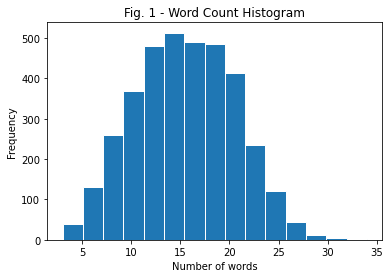

In [22]:
#plotting the histogram
plt.hist(wordCounts, bins=15, edgecolor='white')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Fig. 1 - Word Count Histogram')
plt.show()

In [23]:
#Checking % of upper case words
allWords= tweetsRdd.flatMap(lambda row: row.text.split())
uppercaseWords= allWords.filter(lambda word: word.isupper())

#proportion
uppercaseWords.count() / allWords.count()

0.09354406643450308

### checking most common words

In [24]:
#extracting all words from the tweets, splitting text with a single space
words= tweetsRdd.flatMap(lambda tweet: tweet[1].split(" ")) # flatMap flattens the RDD after applying the function

#Filtering words with >3 characters
filteredWords= words.filter(lambda word: len(word) > 4)



#counting totals per word, case insensitive
wordCounts = filteredWords.map(lambda word: (word.lower(), 1)).reduceByKey(lambda a, b: a + b) # reduceByKey merges the values for each key using an associative and commutative reduce function

In [25]:
# sorting in descending order
sortedWordCounts= wordCounts.sortBy(lambda x: x[1], ascending=False)

# Taking the top 30 words with the highest counts
topWords= sortedWordCounts.take(30)

# Printing the top words
for word, count in topWords:
    print(word,' - ',count)

labeling  -  442
monsanto  -  286
foods  -  266
label  -  208
about  -  204
&amp;  -  169
organic  -  138
crops  -  126
california  -  115
campaign  -  106
health  -  102
monsanto's  -  99
transgenic  -  98
@healthranger  -  96
against  -  87
reject  -  85
please  -  84
seeds  -  83
study  -  79
support  -  78
don't  -  75
@credomobile  -  75
right  -  70
@youtube  -  69
safety  -  68
modified  -  68
genetically  -  66
their  -  63
@signon  -  63
consumer  -  62


In [26]:
# Selecting the first 6 most common words
wordsToRemove=[i[0] for i in topWords][0:6]
wordsToRemove

['labeling', 'monsanto', 'foods', 'label', 'about', '&amp;']

In [27]:
#checking rare words, excluding URLs as there are many and they will be removed anyway
rareWords= sortedWordCounts.top(20, key=lambda x: -x[1] if not x[0].startswith("http://") else float("-inf"))

# Printing the top words
for word, count in rareWords:
    print(word,' - ',count)

settled  -  1
superb  -  1
solution:  -  1
conduct  -  1
tests.  -  1
insane.  -  1
florida??  -  1
implies  -  1
over?"  -  1
pacific,...  -  1
t1c-19  -  1
sprague–dawley  -  1
metabonomics  -  1
insulin-dependant  -  1
diabetics  -  1
crops
  -  1
#wikileaks  -  1
natural’  -  1
@harjxo  -  1
excoexcoexco!  -  1


In [28]:
#Checking the number of numerics. flatMap applys a function to all elements and creates a new rdd
tweetsRdd.flatMap(lambda row: list(filter(lambda char: char.isdigit(), row.text))).count() # filterring out numeric characters

6047

In [29]:
#Proportion of upper case words
totalWords= tweetsRdd.flatMap(lambda row: row.text.split()) #splitting words from all tweets
uppercaseWords= totalWords.filter(lambda word: word.isupper()) #filterring upper case only
uppercaseWords.count() / totalWords.count()

0.09409135603825869

#### Number of stopwords

In [30]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [31]:
#getting stopwords for English language
stopwordsBag= set(stopwords.words('english'))

#splitting text field to single words, filterring stopwords only and counting them
tweetsRdd.flatMap(lambda row: row.text.lower().split()).filter(lambda word: word in stopwordsBag).count()

14238

In [32]:
#number of special characters
#filterring out non-alphanumeric characters. isalnum() returns True if all characters in the string are alphanumeric. Creating a new list convert them into a list.
tweetsRdd.flatMap(lambda row: list(filter(lambda char: not char.isalnum(), row.text))).count()

82325

### checking hashtags

In [33]:
#extracting hashtags from the tweets, splitting text with single space, considering words which start with #
hashtagsRdd = tweetsRdd.flatMap(lambda tweet: tweet[1].split(" ")).filter(lambda word: word.startswith("#"))

# counting totals per hashtag, case insensitive with .lower()
hashtagsTotal= hashtagsRdd.map(lambda hashtag: (hashtag.lower(), 1)).reduceByKey(lambda a, b: a + b)

In [34]:
#top 20 hashtags
topHashtags= hashtagsTotal.takeOrdered(20, key=lambda x: -x[1])

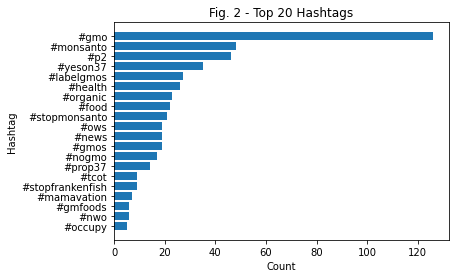

In [35]:
# extracting values to plot
hashtags= [hashtag for (hashtag, count) in topHashtags]
counts= [count for (hashtag, count) in topHashtags]

# Plot the top hashtags
plt.barh(hashtags, counts)
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.title('Fig. 2 - Top 20 Hashtags')
#plt.figure(figsize=(20, 20))#setting size of plot
plt.gca().invert_yaxis()
plt.show()

#### checking double spaces

In [36]:
#fileterring tweets with two consecutive white spaces, row per row, and adding up the counts
tweetsRdd.filter(lambda row: "  " in row[1]).count()

315

In [37]:
#triple spaces
tweetsRdd.filter(lambda row: "   " in row[1]).count()

20

In [38]:
# 4 spaces
tweetsRdd.filter(lambda row: "    " in row[1]).count()

5

In [39]:
#9 spaces
tweetsRdd.filter(lambda row: "         " in row[1]).count()

1

Removing extra white spaces

In [40]:
from pyspark.sql import Row

In [41]:
#function to replace consecutive white spaces with a single space
def singleWspace(row):
    return Row(created_at=row.created_at, text=' '.join(row.text.split()))

In [42]:
# mapping function
tweetsRdd= tweetsRdd.map(singleWspace)

In [43]:
#confirmation
tweetsRdd.filter(lambda row: "  " in row[1]).count()

0

In [44]:
tweetsRdd.filter(lambda row: "   " in row[1]).count()

0

In [45]:
tweetsRdd.first()

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb')

#### Duplicates

Switching to spark data frames

In [46]:
#Updating data frame from rdd after removing non-English tweets
tweetsDf = tweetsRdd.toDF(["created_at", "text"])

In [47]:
tweetsDf.show(n=1)

+-------------------+--------------------+
|         created_at|                text|
+-------------------+--------------------+
|2012-01-02 20:09:42|USDA has settled ...|
+-------------------+--------------------+
only showing top 1 row



In [48]:
tweetsDf.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- text: string (nullable = true)



In [49]:
tweetsDf.count()

3603

In [50]:
#grouping by text and counting them
duplicates= tweetsDf.groupBy('text').count()

# filtering the rows with count >= 2 
duplicates= duplicates.filter(duplicates['count'] > 1)

duplicates.show()

+--------------------+-----+
|                text|count|
+--------------------+-----+
|People power caus...|    2|
|We are helping cu...|    2|
|Healthy Budget: G...|    5|
|At Disney World's...|    2|
|#USDA to Give #Mo...|    2|
|Pesticide Use Ram...|    2|
|good going Boulde...|    2|
|STOP MONSANTO FRO...|    2|
|#Hungary Destroys...|    2|
|Just played: GMO ...|    3|
|Mommy, what does ...|    2|
|Tell .@BarackObam...|    2|
|GMO updates,Femal...|    2|
|Healthy Budget: G...|    4|
+--------------------+-----+



In [51]:
#viewing duplicates fully
duplicates.select('text').show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|People power causes GMO firm to move from Europe to the US. http://t.co/TSaxGffw #GMOs #geneticallymodified #health                         |
|We are helping customers and team members get informed about GMOs via our in-store info centers. Visit one in our stores today.             |
|Healthy Budget: Growing with Non GMO Seed for Home Garden http://t.co/eJXmLWMt #Organic                                                     |
|At Disney World's exhibit, teaching children about GMO agriculture is a "fun activity" http://t.co/EOKSqbGh @TrueFoodAust @TransitionSyd    |

In [52]:
# #dropping duplicates, keeping the oldest only
# tweetsDf= tweetsDf.dropDuplicates(subset=['text'])

In [53]:
# oldest and latest dates in df
oldestDate= tweetsDf.select(min('created_at')).first()[0].date()
latestDate= tweetsDf.select(max('created_at')).first()[0].date()

print(' Between\n',oldestDate,'\n and\n',latestDate,'\n')

 Between
 2012-01-02 
 and
 2013-03-01 



In [54]:
#timestamps with greatest count of tweets. Extracting timestamps with module 'functions' and aggregating counts, which are shown in a new column, descendent ordered  
tweetsDf.groupBy('created_at').agg(F.count('*').alias('count')).orderBy(F.desc('count')).show()

+-------------------+-----+
|         created_at|count|
+-------------------+-----+
|2012-11-15 04:15:07|    3|
|2012-05-14 23:18:35|    2|
|2012-01-09 15:11:39|    2|
|2012-11-05 07:56:09|    2|
|2012-05-12 14:49:03|    2|
|2012-09-25 03:20:02|    2|
|2012-02-17 01:11:07|    2|
|2012-02-19 15:47:42|    2|
|2012-10-11 07:00:16|    2|
|2013-01-30 00:36:15|    2|
|2012-03-02 02:43:23|    2|
|2012-01-21 00:31:13|    1|
|2012-09-19 18:04:04|    1|
|2012-02-09 16:52:34|    1|
|2012-10-04 16:30:34|    1|
|2012-11-10 15:17:56|    1|
|2012-06-02 05:22:09|    1|
|2012-10-07 18:37:40|    1|
|2012-11-26 18:55:10|    1|
|2012-07-06 13:15:52|    1|
+-------------------+-----+
only showing top 20 rows



In [55]:
#same as above but excluding seconds, using date_format and extracting date, hours and minutes only
tweetsDf.groupBy(
    F.date_format('created_at', 'yyyy-MM-dd').alias('date'),
    F.date_format('created_at', 'HH').alias('hour'),
    F.date_format('created_at', 'MM').alias('minute')
).agg(F.count('*').alias('count')).orderBy(F.desc('count')).show() #aggregating counts of timestamps (tweets) producing a new column

+----------+----+------+-----+
|      date|hour|minute|count|
+----------+----+------+-----+
|2012-11-07|  14|    11|    7|
|2012-11-06|  19|    11|    6|
|2012-11-06|  16|    11|    6|
|2012-08-23|  19|    08|    6|
|2013-02-16|  16|    02|    6|
|2012-09-15|  22|    09|    6|
|2012-09-13|  03|    09|    6|
|2012-10-03|  19|    10|    5|
|2012-09-23|  17|    09|    5|
|2012-09-28|  15|    09|    5|
|2012-09-29|  17|    09|    5|
|2012-04-03|  04|    04|    5|
|2012-09-28|  17|    09|    5|
|2013-01-08|  17|    01|    4|
|2012-12-03|  19|    12|    4|
|2012-11-08|  16|    11|    4|
|2012-09-21|  11|    09|    4|
|2012-11-07|  17|    11|    4|
|2012-10-06|  15|    10|    4|
|2012-02-16|  22|    02|    4|
+----------+----+------+-----+
only showing top 20 rows



In [56]:
#same as above but also excluding minutes, using date_format and extracting date and hours only
tweetsDf.groupBy(
    F.date_format('created_at', 'yyyy-MM-dd').alias('date'),
    F.date_format('created_at', 'HH').alias('hour')
).agg(F.count('*').alias('count')).orderBy(F.desc('count')).show() #aggregating counts of timestamps (tweets) producing a new column

+----------+----+-----+
|      date|hour|count|
+----------+----+-----+
|2012-11-07|  14|    7|
|2012-09-13|  03|    6|
|2012-08-23|  19|    6|
|2012-11-06|  19|    6|
|2012-11-06|  16|    6|
|2012-09-15|  22|    6|
|2013-02-16|  16|    6|
|2012-10-03|  19|    5|
|2012-09-28|  17|    5|
|2012-04-03|  04|    5|
|2012-09-28|  15|    5|
|2012-09-29|  17|    5|
|2012-09-23|  17|    5|
|2012-11-07|  05|    4|
|2012-10-11|  18|    4|
|2013-02-28|  01|    4|
|2012-04-05|  22|    4|
|2012-12-03|  19|    4|
|2012-09-29|  01|    4|
|2012-10-18|  03|    4|
+----------+----+-----+
only showing top 20 rows



### Dates without tweets (~missing dates)

In [57]:
print(' Between\n',oldestDate,'\n and\n',latestDate,'\n')

#converting dates to Unix timestamps -> int() cannot be datetime.date
oldestDate= int(oldestDate.strftime("%s"))
latestDate= int(latestDate.strftime("%s"))

#generating the list of dates. 86400 s/day
timeRange= spark.range(start=oldestDate, end=latestDate, step=86400).selectExpr("to_date(from_unixtime(id)) as date")



#Listing missing dates with anti-join between the date range and the 'created_at' column. 
missingDates= timeRange.join(tweetsDf, timeRange.date == tweetsDf.created_at.cast(DateType()), 'leftanti') # leftanti selects the rows from the left df that do not have a matching key from the right df


print(" there are missing dates->",missingDates.count());missingDates.show()

 Between
 2012-01-02 
 and
 2013-03-01 



 there are missing dates-> 5


+----------+
|      date|
+----------+
|2012-12-28|
|2012-12-30|
|2012-02-05|
|2012-12-31|
|2012-12-29|
+----------+



#### Checking number of natural hours per day that hold tweets

In [58]:
#grouping by date and count unique hours. Extranting features with module 'functions'. Counts the unique hours per day and aggregates the totals in a new column
hourlyPerDay = tweetsDf.groupBy(F.to_date('created_at').alias('date')).agg(F.countDistinct(F.hour('created_at')).alias('uniqueHourCount'))

hourlyPerDay.orderBy(desc('uniqueHourCount')).show() # ORDENADOS DESCENDENTEMENTE PARA VER LO Q SERIA LA MEJOR PARTE, QUE EN REALIDAD EVIDENCIA QUE NO ES BUENA, AUNQ EL NUMERO DE TWEETS NO ES ALTO DE PRIMERAS

+----------+---------------+
|      date|uniqueHourCount|
+----------+---------------+
|2012-09-24|             18|
|2012-09-26|             18|
|2012-09-20|             17|
|2012-10-03|             17|
|2012-09-28|             17|
|2012-10-05|             16|
|2012-09-27|             16|
|2012-11-07|             16|
|2012-10-21|             15|
|2012-10-27|             15|
|2012-11-06|             15|
|2012-09-21|             14|
|2012-10-24|             14|
|2012-06-24|             14|
|2012-09-23|             14|
|2012-02-29|             14|
|2012-10-09|             14|
|2012-11-03|             13|
|2012-11-14|             13|
|2012-10-08|             13|
+----------+---------------+
only showing top 20 rows



In [59]:
#checking percentiles
hourlyPerDay.toPandas().describe(percentiles=[0.25, 0.5, 0.75])

,uniqueHourCount
count,420.000000
mean,6.585714
std,3.323423
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,18.000000


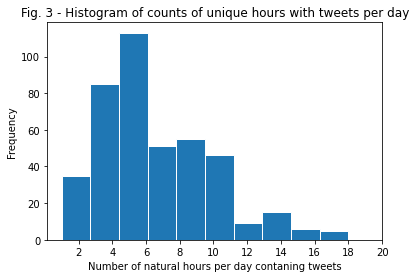

In [60]:
#transforming to pandas for the histogram 
plt.hist(hourlyPerDay.toPandas()['uniqueHourCount'], bins=10, edgecolor='white')

#Arranging axis labels, ticks, title
plt.xlabel('Number of natural hours per day contaning tweets')
plt.ylabel('Frequency')
plt.xticks(np.arange(2,21,2))
plt.title('Fig. 3 - Histogram of counts of unique hours with tweets per day')

plt.show()

## Basic plots

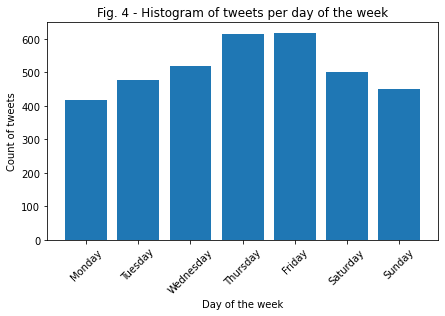

In [61]:
from pyspark.sql.functions import count

#extracting each of the days of the week
tweetsDf= tweetsDf.withColumn('day_of_week', dayofweek('created_at'))

# counting number of tweets by day of the week by adding a new column
tweetCounts= tweetsDf.groupBy('day_of_week').agg(count('*').alias('count'))


dayLabels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(7, 4))#setting size of plot
plt.bar(tweetCounts.toPandas()['day_of_week'], tweetCounts.toPandas()['count'])#need to convert to pandas

#Arranging axis labels, ticks, title
plt.xlabel('Day of the week')
plt.ylabel('Count of tweets')
plt.title('Fig. 4 - Histogram of tweets per day of the week')
plt.xticks(range(1, 8), dayLabels, rotation=45)
plt.show()

In [62]:
tweetCounts

DataFrame[day_of_week: int, count: bigint]

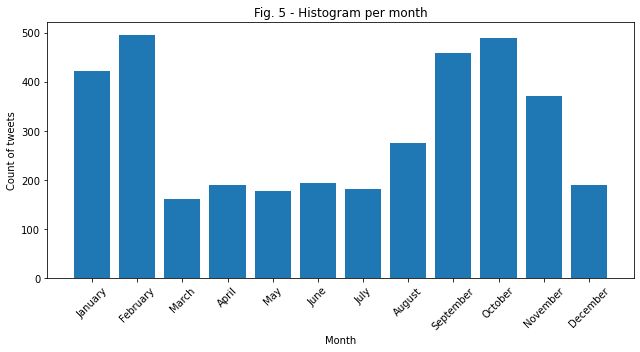

In [63]:
# extracting months
tweetsDf= tweetsDf.withColumn('month', month('created_at'))

#same as before adding a new column with counts
tweetCounts= tweetsDf.groupBy('month').agg(count('*').alias('count'))



monthLabels= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


plt.figure(figsize=(9, 5))
plt.bar(tweetCounts.toPandas()['month'], tweetCounts.toPandas()['count'])
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.title('Fig. 5 - Histogram per month')
plt.xticks(range(1, 13), monthLabels,rotation=45)
plt.tight_layout()
plt.show()

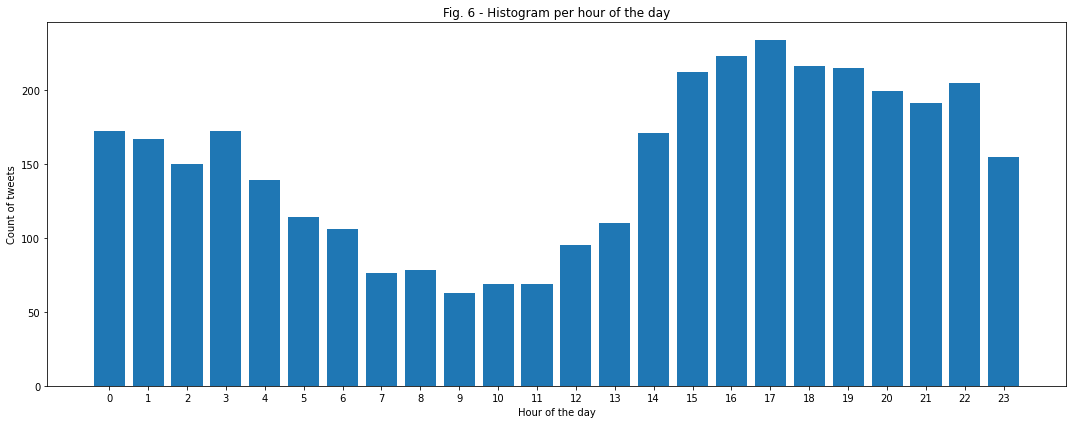

In [64]:
#extracting each of the 24 hours of a day
tweetsDf= tweetsDf.withColumn('hour_of_day', hour('created_at'))

#adding column with counts
tweetCounts= tweetsDf.groupBy('hour_of_day').agg(count('*').alias('count'))


plt.figure(figsize=(15, 6))
plt.bar(tweetCounts.toPandas()['hour_of_day'], tweetCounts.toPandas()['count'])
plt.xlabel('Hour of the day')
plt.ylabel('Count of tweets')
plt.title('Fig. 6 - Histogram per hour of the day')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

## cleaning RDD 

Before removing hashtags, assigning -1 to tweets including '#stopmonsanto' or '#nogmo' or '#stopfrankenfish'

In [65]:
from pyspark.sql import Row

In [66]:
#creating function to assign -1 sentiment score to certain tweets. Else 'None'
def addNegativeSentScore(row):
    
    #selecting text field for each row, making it lower case to match the strings below
    text = row.text.lower()
    
    if '#stopmonsanto' in text or '#nogmo' in text or '#stopfrankenfish' in text:
        sentiment_score = -1
        
    else:
        sentiment_score = None
    
    return Row(created_at=row.created_at, text=row.text, sentimentScore=sentiment_score)

#applying function
tweetsRddScore = tweetsRdd.map(addNegativeSentScore)

In [67]:
#checking number of sentimentScore assigned
tweetsRddScore.filter(lambda row: row.sentimentScore == -1).count()

47

##### data cleaning

In [68]:
import re # regular expressions
from pyspark.ml.feature import StopWordsRemover
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
# stopwords for English
stopwords = set(stopwords.words('english'))

In [70]:
# Cleaning up tweets
def clean_text(row):
    text = row.text

    # removing links
    text = re.sub(r'http\S+', '', text)

    # hashtags
    text = re.sub(r'#\w+', '', text)
    
    # user mentions -starting with @-
    text = re.sub(r'@\w+', '', text)

    # special characters 
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # in case there are single characters
    text = re.sub(r'\b\w\b', '', text)

    
    #tokenizing text into words
    tokens = word_tokenize(text)

    # removing stopwords, common words and making it lower case
    woTokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.lower() not in wordsToRemove]

    
    # spelling correction
    corrected_tokens = [str(TextBlob(token).correct()) for token in woTokens]

    # lemmatizing words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in corrected_tokens]

    # joining tokens back
    cleaned_text = ' '.join(lemmatized_tokens)

    return Row(created_at=row.created_at, text=cleaned_text, sentimentScore=row.sentimentScore)

In [71]:
# applying function to the RDD
cleanedRdd = tweetsRddScore.map(clean_text)

In [72]:
cleanedRdd.first()

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='u settled upon superb solution let go industry conduct environmental impact test', sentimentScore=None)

In [73]:
cleanedRdd.count()

3602

### Assigning a sentiment score

In [74]:
#!pip install textblob

In [75]:
def sentimentScore(row):
    text = row.text
    
    # Check if sentimentScore is already assigned
    if row.sentimentScore is None:
        # Creating TextBlob object
        blob = TextBlob(text)

        # Getting polarity score
        polarity = blob.sentiment.polarity

        # Updating row with sentiment score
        return Row(created_at=row.created_at, text=row.text, sentimentScore=polarity)
    
    # Return the row as it is if sentimentScore is already assigned
    return row

In [76]:
#applying function
sentimentRdd = cleanedRdd.map(sentimentScore)

In [77]:
sentimentRdd.first()

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='u settled upon superb solution let go industry conduct environmental impact test', sentimentScore=1.0)

In [78]:
# number of tweets
tweetsNumber = sentimentRdd.count()


#tweets with score > 0.3 (+ sentiment)
positiveTweets = sentimentRdd.filter(lambda row: row.sentimentScore > 0.33).count()

# tweets with score < -0.3 (- sentiment)
negativeTweets = sentimentRdd.filter(lambda row: row.sentimentScore < -0.33).count()


# proportions
positivePercent = (positiveTweets / tweetsNumber)*100
negativePercent = (negativeTweets / tweetsNumber)*100

In [79]:
print(round(positivePercent,1),'% of tweets with positive sentiment')
print(round(negativePercent,1),'% of tweets with negative sentiment')
print(round(100-positivePercent-negativePercent,1),'% of tweets with neutral sentiment')

14.3 % of tweets with positive sentiment
6.6 % of tweets with negative sentiment
79.1 % of tweets with neutral sentiment


##### Boxplots
checking distributions

In [80]:
# converting rdd to df
sentimentDf= sentimentRdd.toDF()

#extracting year and month from timestmap
sentimentDf= sentimentDf.withColumn('year', year(sentimentDf['created_at']))
sentimentDf= sentimentDf.withColumn('month', month(sentimentDf['created_at']))

#converting df to pandas df
sentimentPd = sentimentDf.toPandas()

# filterring data from year 2012
sentimentPd_2012 = sentimentPd[sentimentPd['year'] == 2012]

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


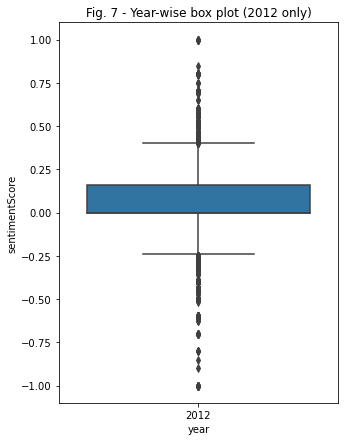

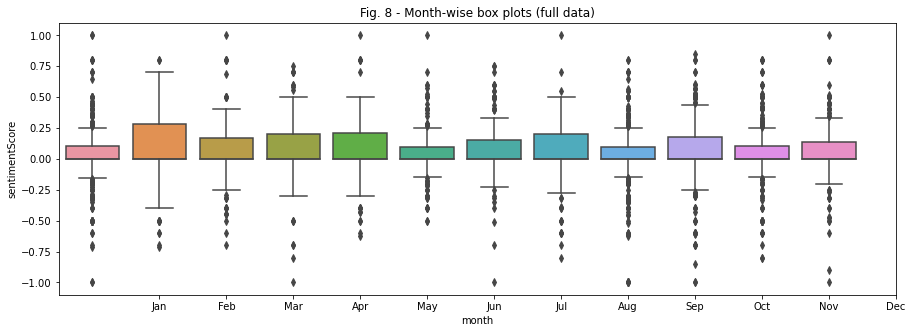

In [81]:
# year-wise Box Plot for 2012
plt.figure(figsize=(5, 7))
sns.boxplot(x='year', y='Sentiment score', data=sentimentPd_2012)
plt.title('Fig. 7 - Year-wise box plot (2012 only)')
plt.show()

# month-wise Box Plots for 2012 and 2013
plt.figure(figsize=(15, 5))
sns.boxplot(x='month', y='Sentiment score', data=sentimentPd)
plt.title('Fig. 8 - Month-wise box plots (full data)')

# setting x-axis labels as month names
plt.xticks(range(1, 13), pd.date_range(start='2022-01', periods=12, freq='M').strftime('%b'))

plt.show()

#### aggregating by natural day

In [82]:
from pyspark.sql.functions import to_date, avg, format_number

In [83]:
sentimentDf = spark.createDataFrame(sentimentRdd, ['created_at', 'text'])

#grouping df by date. Get average score per day and sort by date
averageScores = sentimentDf.groupBy(to_date('created_at').alias('date')).agg(format_number(avg('sentimentScore'),2).alias('averageScore')).orderBy(F.asc('date'))

averageScores.show()

+----------+------------+
|      date|averageScore|
+----------+------------+
|2012-01-02|        1.00|
|2012-01-03|       -0.04|
|2012-01-04|        0.00|
|2012-01-05|       -0.00|
|2012-01-06|        0.13|
|2012-01-07|       -0.06|
|2012-01-08|       -0.10|
|2012-01-09|        0.09|
|2012-01-10|        0.05|
|2012-01-11|       -0.15|
|2012-01-12|       -0.17|
|2012-01-13|       -0.04|
|2012-01-14|       -0.15|
|2012-01-15|       -0.03|
|2012-01-16|        0.11|
|2012-01-17|       -0.04|
|2012-01-18|       -0.05|
|2012-01-19|       -0.03|
|2012-01-20|        0.16|
|2012-01-21|       -0.07|
+----------+------------+
only showing top 20 rows



In [84]:
#converting to pandas
averageScoresPd = averageScores.toPandas()
averageScoresPd['averageScore']= averageScoresPd['averageScore'].astype(float).round(decimals=2) #averageScore needs to be reconverted as float so that it is ordered in the y axis
averageScoresPd

,date,averageScore
0,2012-01-02,1.00
1,2012-01-03,-0.04
2,2012-01-04,0.00
3,2012-01-05,-0.00
4,2012-01-06,0.13
...,...,...
415,2013-02-25,0.06
416,2013-02-26,0.00
417,2013-02-27,-0.03
418,2013-02-28,0.19


In [85]:
averageScoresPd.describe()

,averageScore
count,420.000000
mean,0.067286
std,0.118272
min,-0.280000
25%,0.000000
50%,0.060000
75%,0.130000
max,1.000000


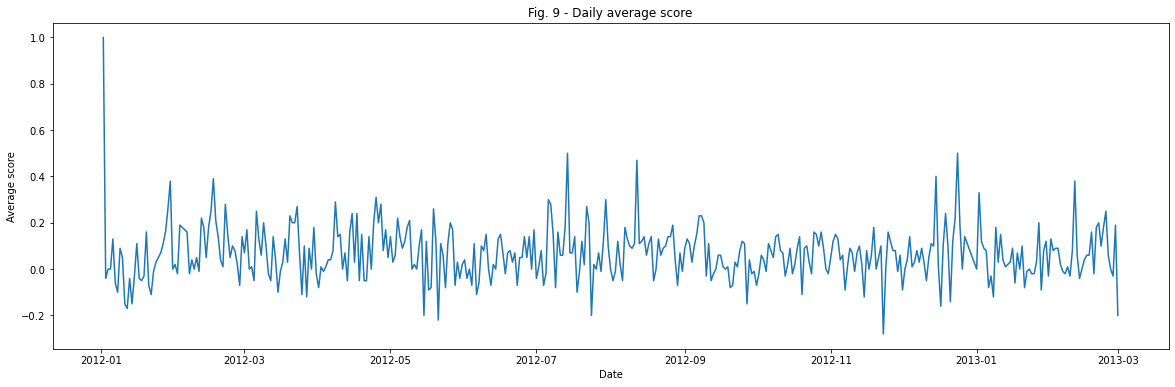

In [86]:
# Plot the average score per day
plt.figure(figsize=(20, 6))  # Set the figure size

# Plotting scores
plt.plot(averageScoresPd['date'], averageScoresPd['averageScore']) 

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Average score')
plt.title('Fig. 9 - Daily average score')
plt.show()

Adding missing dates and filling scores with NaNs

In [87]:
len(averageScoresPd)

420

In [88]:
averageScoresPd.index

RangeIndex(start=0, stop=420, step=1)

In [89]:
#setting date column as index
averageScoresPd.set_index('date', inplace=True)

In [90]:
averageScoresPd.index

Index([2012-01-02, 2012-01-03, 2012-01-04, 2012-01-05, 2012-01-06, 2012-01-07,
       2012-01-08, 2012-01-09, 2012-01-10, 2012-01-11,
       ...
       2013-02-20, 2013-02-21, 2013-02-22, 2013-02-23, 2013-02-24, 2013-02-25,
       2013-02-26, 2013-02-27, 2013-02-28, 2013-03-01],
      dtype='object', name='date', length=420)

In [91]:
# generating a date range 
dateRange= pd.date_range(start=averageScoresPd.index.min(), end=averageScoresPd.index.max(), freq='D')#daily frequence

# reindexing df with the date range. Missing scores filled with NaN
averageScoresPd= averageScoresPd.reindex(dateRange)



#reseting index to include the 'date' column
averageScoresPd.reset_index(inplace=True)
averageScoresPd.rename(columns={'index': 'date'}, inplace=True)

# Sort the DataFrame by date
averageScoresPd.sort_values('date', inplace=True)

In [92]:
averageScoresPd.set_index('date', inplace=True)

In [93]:
averageScoresPd

,averageScore
date,
2012-01-02,1.00
2012-01-03,-0.04
2012-01-04,0.00
2012-01-05,-0.00
2012-01-06,0.13
...,...
2013-02-25,0.06
2013-02-26,0.00
2013-02-27,-0.03


In [94]:
averageScoresPd.isnull().sum()

averageScore    5
dtype: int64

In [95]:
averageScoresPd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2012-01-02 to 2013-03-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   averageScore  420 non-null    float64
dtypes: float64(1)
memory usage: 6.6 KB


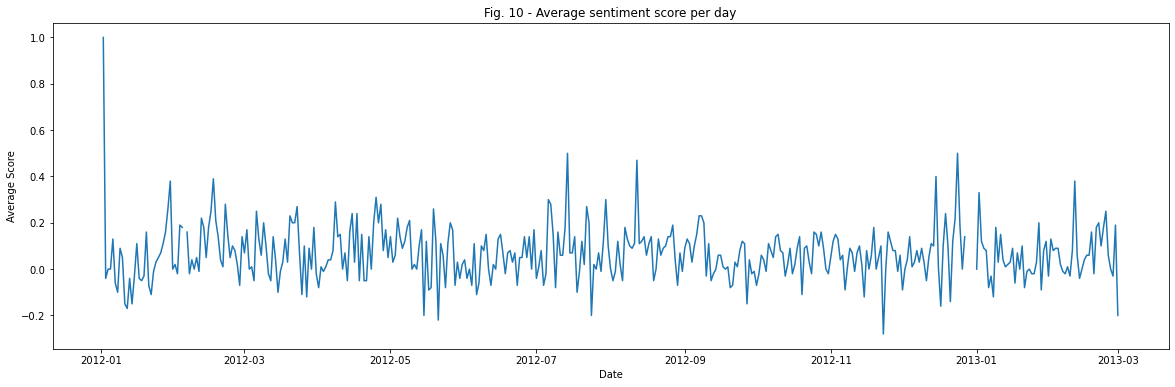

In [96]:
# Plot the average score per day
plt.figure(figsize=(20, 6))  # Set the figure size

# Plotting scores
plt.plot(averageScoresPd) 

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.title('Fig. 10 - Average sentiment score per day')
plt.show()

In [97]:
averageScoresPd

,averageScore
date,
2012-01-02,1.00
2012-01-03,-0.04
2012-01-04,0.00
2012-01-05,-0.00
2012-01-06,0.13
...,...
2013-02-25,0.06
2013-02-26,0.00
2013-02-27,-0.03


### Inputation

In [98]:
# getting indexes of NaNs with isna() method along y axis
nanIndex= averageScoresPd[pd.isna(averageScoresPd).any(axis=1)].index
nanIndex

DatetimeIndex(['2012-02-05', '2012-12-28', '2012-12-29', '2012-12-30',
               '2012-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [99]:
averageScoresPd.loc[nanIndex]

,averageScore
date,
2012-02-05,NaN
2012-12-28,NaN
2012-12-29,NaN
2012-12-30,NaN
2012-12-31,NaN


Addressing the four consecutive NaNs in December

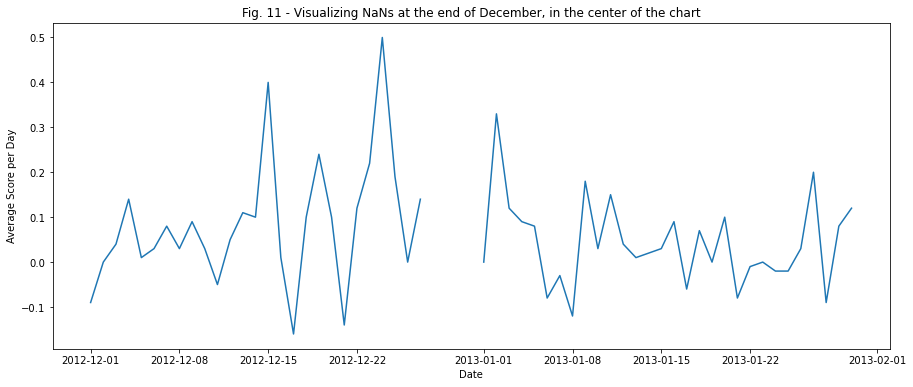

In [100]:
# Putting them in closer context, visualizing two months

#selecting the frame
interpol= averageScoresPd.loc['2012-12-01':'2013-01-30']

plt.figure(figsize=(15, 6))  #set the figure size


# Plotting scores
plt.plot(interpol) 

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Average Score per Day')
plt.title('Fig. 11 - Visualizing NaNs at the end of December, in the center of the chart')
plt.show()

In [101]:
# duplicating df for tests
interpol2= averageScoresPd

#triggering three interpolation types with pandas
linInt= interpol2['averageScore'].interpolate(method='linear')
quadInt= interpol2['averageScore'].interpolate(method='quadratic')
cubInt= interpol2['averageScore'].interpolate(method='cubic')

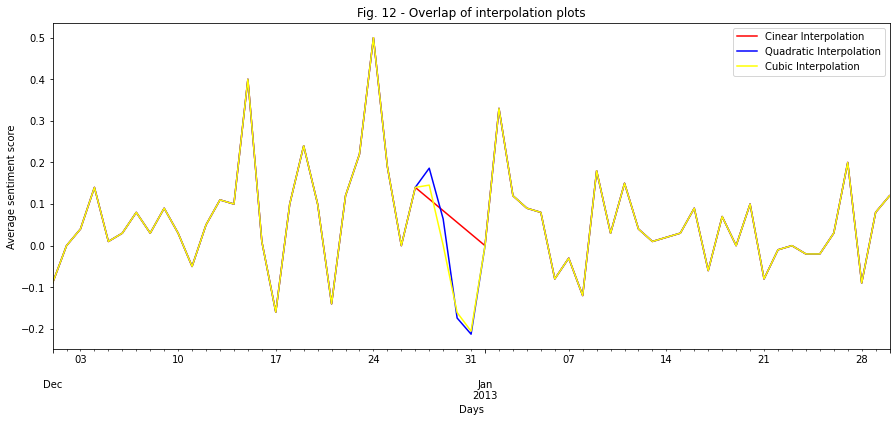

In [102]:
# creating a figure with its size and axis
fig, ax = plt.subplots(figsize=(15, 6))

# plotting each df on the same axis. loc[] selects the index range to focus on
linInt.loc['2012-12-01':'2013-01-30'].plot(ax=ax, color='red', label='Cinear Interpolation')
quadInt.loc['2012-12-01':'2013-01-30'].plot(ax=ax, color='blue', label='Quadratic Interpolation')
cubInt.loc['2012-12-01':'2013-01-30'].plot(ax=ax, color='yellow', label='Cubic Interpolation')

# setting axis labels and title
ax.set_xlabel('Days')
ax.set_ylabel('Average sentiment score')
ax.set_title('Fig. 12 - Overlap of interpolation plots')

ax.legend()

plt.show()

In [103]:
#filling remaining NaNs with quadratic interpolation
averageScoresPd= averageScoresPd['averageScore'].interpolate(method='quadratic')

In [104]:
averageScoresPd.loc[nanIndex]

date
2012-02-05    0.201194
2012-12-28    0.186201
2012-12-29    0.064032
2012-12-30   -0.174000
2012-12-31   -0.212847
Name: averageScore, dtype: float64

Final plot

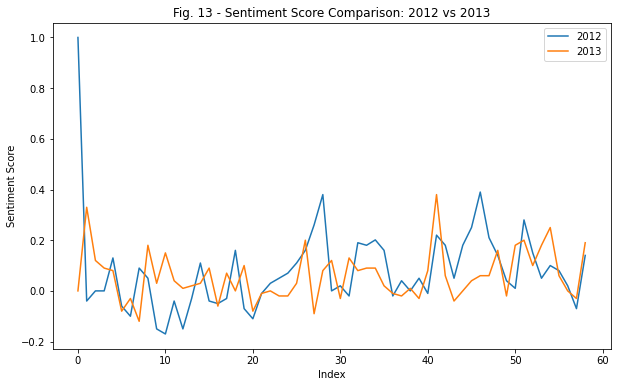

In [105]:
#filterring the df with loc[], which selects the index range to focus on 
df_2012 = averageScoresPd.loc['2012-01':'2012-02']
df_2013 = averageScoresPd.loc['2013-01':'2013-02']

# resetting the index of the dfs
df_2012 = df_2012.reset_index()
df_2013 = df_2013.reset_index()

# creating a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# plotting the data for 2012
ax.plot(df_2012.index, df_2012['averageScore'], label='2012')

# plotting the data for 2013
ax.plot(df_2013.index, df_2013['averageScore'], label='2013')

# set the axis labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Sentiment Score')
ax.set_title('Fig. 13 - Sentiment Score Comparison: 2012 vs 2013')

# adding the legend we assigned with .plot()
ax.legend()

plt.show()

#### Time series decomposition into components

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

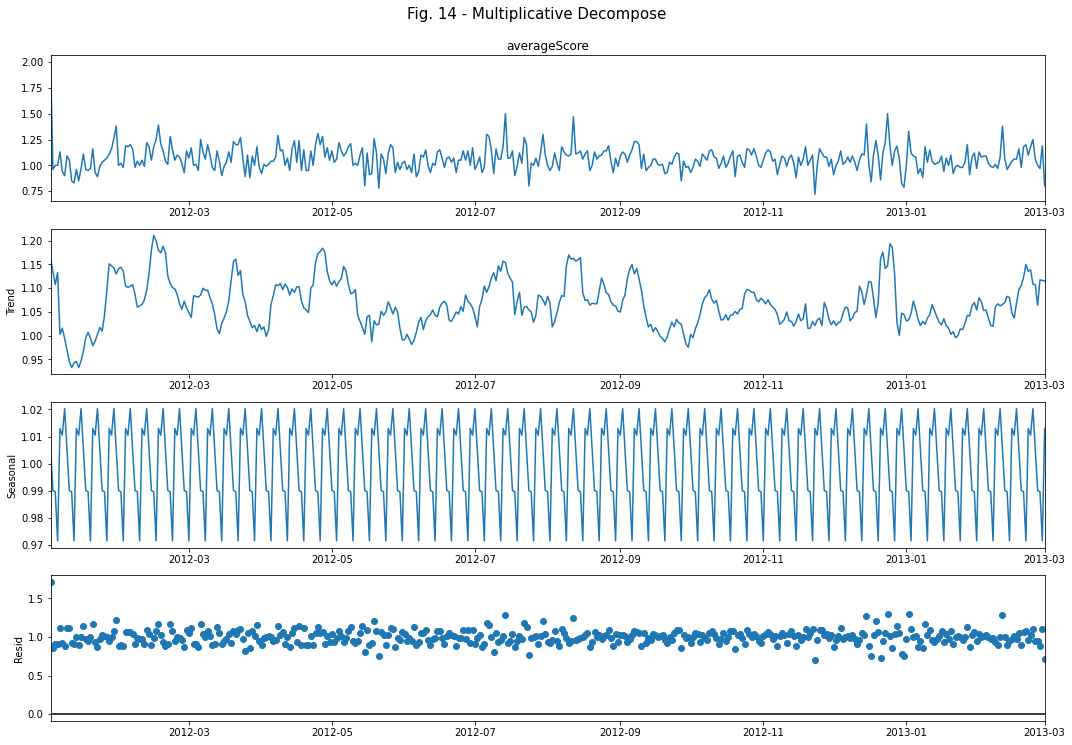

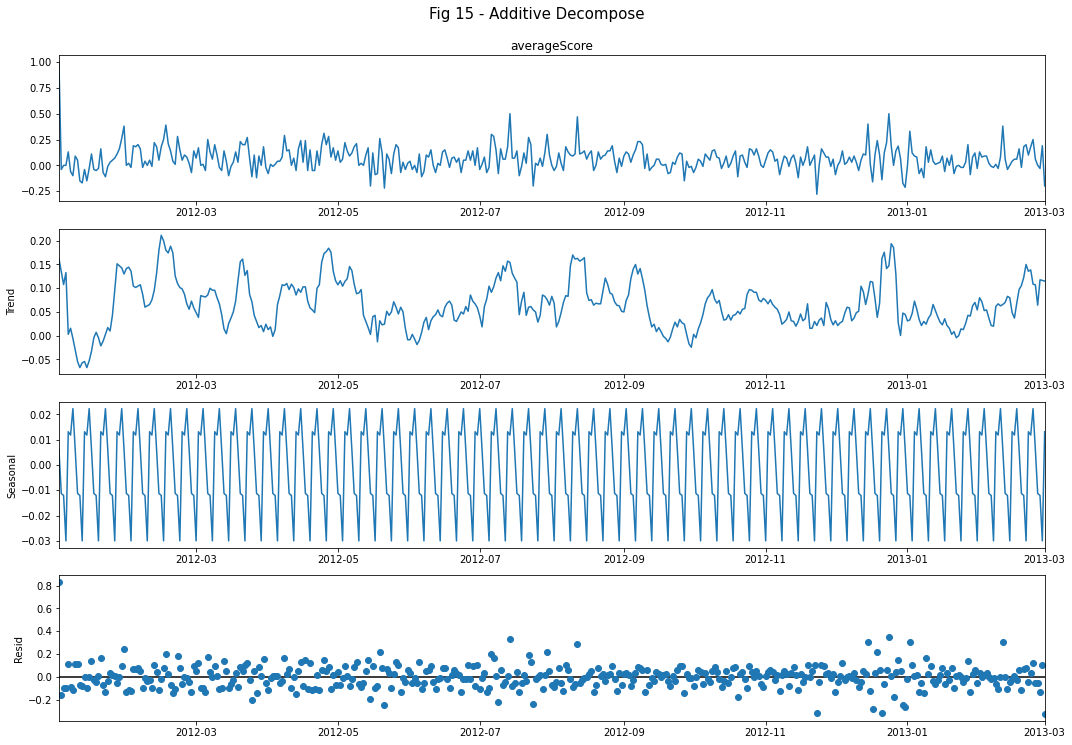

In [107]:
# Multiplicative Decomposition, added 1 to all values to avoid negative scores. The signal of the data remains the same
result_mul = seasonal_decompose(averageScoresPd+1, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(averageScoresPd, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (15,10)})
result_mul.plot().suptitle('Fig. 14 - Multiplicative Decompose', fontsize=15, y=1.03)
result_add.plot().suptitle('Fig 15 - Additive Decompose', fontsize=15, y=1.03)
plt.show()

In [108]:
# Extract the components
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2012-01-02,1.005071,1.162041,1.712427,2.00
2012-01-03,0.990084,1.134898,0.854362,0.96
2012-01-04,0.989595,1.107755,0.912218,1.00
2012-01-05,0.971457,1.132857,0.908660,1.00
2012-01-06,1.012981,1.002857,1.112342,1.13


Checking seasonality with autocorrelation plot

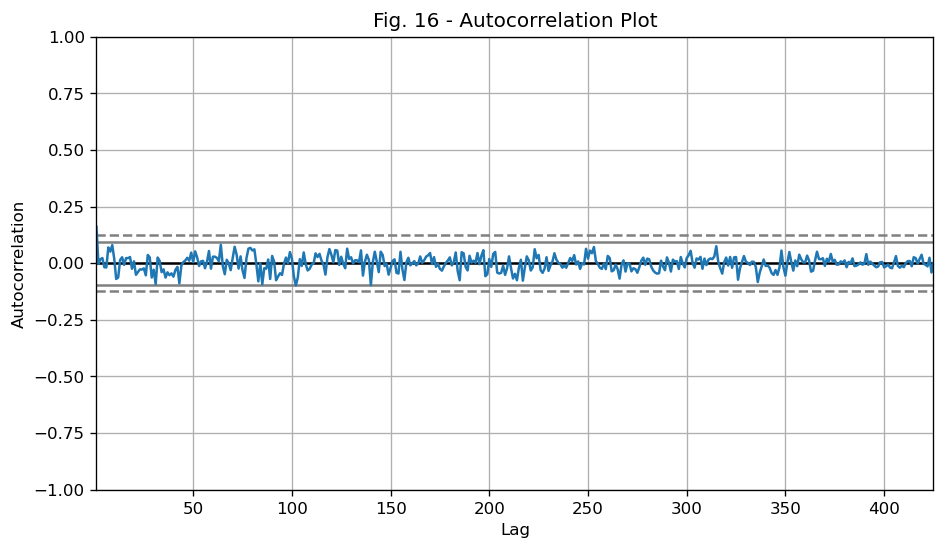

In [354]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(averageScoresPd.tolist())

# Add Title
plt.title('Fig. 16 - Autocorrelation Plot')

plt.show()

#### Stationarity

In [109]:
from statsmodels.tsa.stattools import adfuller, kpss

In [110]:
# ADF Test
result = adfuller(averageScoresPd, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

    
# KPSS Test
result = kpss(averageScoresPd, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -18.781515126332135
p-value: 2.0242029807354006e-30
Critial Values:
   1%, -3.445867291195605
Critial Values:
   5%, -2.868380822100627
Critial Values:
   10%, -2.5704139268867925

KPSS Statistic: 0.204141
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [221]:
averageScoresPd

date
2012-01-02    1.00
2012-01-03   -0.04
2012-01-04    0.00
2012-01-05   -0.00
2012-01-06    0.13
              ... 
2013-02-25    0.06
2013-02-26    0.00
2013-02-27   -0.03
2013-02-28    0.19
2013-03-01   -0.20
Name: averageScore, Length: 425, dtype: float64

#### Making the series stationary: differencing

In [350]:
stationSeries= stationSeries.diff().dropna()

In [351]:
# ADF Test
result = adfuller(stationSeries, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

    
# KPSS Test
result = kpss(stationSeries, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -19.28669799096716
p-value: 0.0
Critial Values:
   1%, -3.4469717056192213
Critial Values:
   5%, -2.868866381945153
Critial Values:
   10%, -2.570672761197837

KPSS Statistic: 0.050434
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [352]:
stationSeries

date
2012-01-12    15.60
2012-01-13     4.77
2012-01-14    -9.53
2012-01-15     2.87
2012-01-16    -3.51
              ...  
2013-02-25   -30.96
2013-02-26     6.51
2013-02-27     3.23
2013-02-28     5.89
2013-03-01   -20.87
Name: averageScore, Length: 415, dtype: float64

#### Detrending timeseries

In [123]:
# # Using statmodels: Subtracting the Trend Component.
# from statsmodels.tsa.seasonal import seasonal_decompose

# result_mul = seasonal_decompose(averageScoresPd+1, model='multiplicative', extrapolate_trend='freq')
# detrended = averageScoresPd - result_mul.trend
# plt.plot(detrended)
# plt.title('Fig. 17 - Sentiment score detrended by subtracting the trend component', fontsize=16)

In [124]:
# # Using scipy: Subtract the line of best fit
# from scipy import signal
# detrended = signal.detrend(averageScoresPd)
# plt.plot(detrended)
# plt.title('Fig. 16 - Sentiment score on GMOs twitter data set detrended by subtracting the least squares fit', fontsize=16)

In [125]:
# # Using statmodels: Subtracting the Trend Component.
# from statsmodels.tsa.seasonal import seasonal_decompose

# result_mul = seasonal_decompose(averageScoresPd+1, model='multiplicative', extrapolate_trend='freq')
# detrended = (averageScoresPd+1) - result_mul.trend
# plt.plot(detrended)
# plt.title('Fig 17. Sentiment score detrended by subtracting the trend component', fontsize=16)

##### Deseasonalization

In [353]:
# # Time Series Decomposition
# result_mul = seasonal_decompose(averageScoresPd+1, model='multiplicative', extrapolate_trend='freq')

# # Deseasonalize
# deseasonalized = (averageScoresPd+1) / result_mul.seasonal

# # Plot
# plt.plot(deseasonalized)
# plt.title('Fig. 18, Sentiment score deseasonalized', fontsize=16)
# plt.plot()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


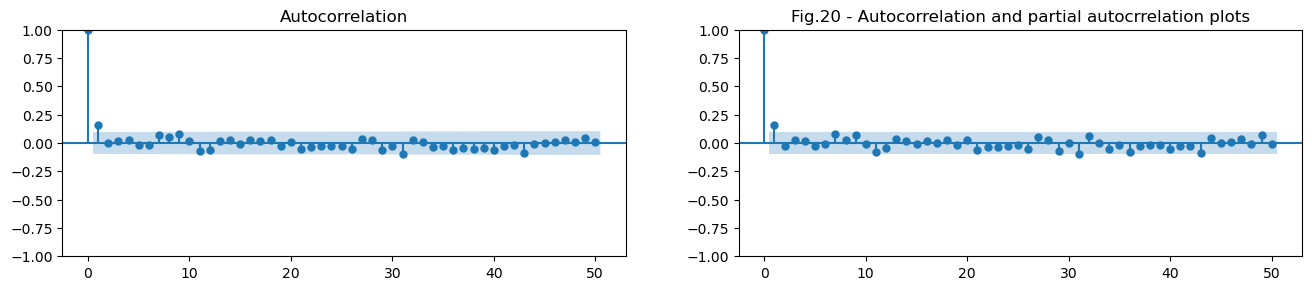

In [116]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(averageScoresPd.tolist(), lags=50, ax=axes[0])
plot_pacf(averageScoresPd.tolist(), lags=50, ax=axes[1])

# Add Title
plt.title('Fig.20 - Autocorrelation and partial autocrrelation plots')

plt.show()

### MOVING AVERAGE

In [356]:
from statsmodels.tsa.arima.model import ARIMA
from random import random

In [375]:
averageScoresPd2.index.freq = pd.infer_freq(averageScoresPd2.index)

In [380]:
averageScoresPd

date
2012-01-02    1.00
2012-01-03   -0.04
2012-01-04    0.00
2012-01-05   -0.00
2012-01-06    0.13
              ... 
2013-02-25    0.06
2013-02-26    0.00
2013-02-27   -0.03
2013-02-28    0.19
2013-03-01   -0.20
Freq: D, Name: averageScore, Length: 425, dtype: float64

In [391]:
model = ARIMA(averageScoresPd, order=(0, 0, 1))
#model_fit = model.fit()

trainSize = int(len(averageScoresPd) * 0.8)
trainData = averageScoresPd[:trainSize]
testData = averageScoresPd[trainSize:]

yhat = model_fit.predict(len(averageScoresPd), len(averageScoresPd))
print(yhat)

foreW = model_fit.forecast(steps=7)[0]
foreM = model_fit.forecast(steps=30)[0]
foreMs = model_fit.forecast(steps=90)[0]

2013-03-02    0.006662
Freq: D, dtype: float64


In [406]:
index_range_W = range(trainSize, trainSize + len(foreW))
index_range_M = range(trainSize, trainSize + len(foreM))
index_range_Ms = range(trainSize, trainSize + len(foreMs))

TypeError: object of type 'numpy.float64' has no len()

In [404]:
foreW = model_fit.forecast(steps=7)[0]
foreM = model_fit.forecast(steps=30)[0]
foreMs = model_fit.forecast(steps=90)[0]

TypeError: object of type 'numpy.float64' has no len()

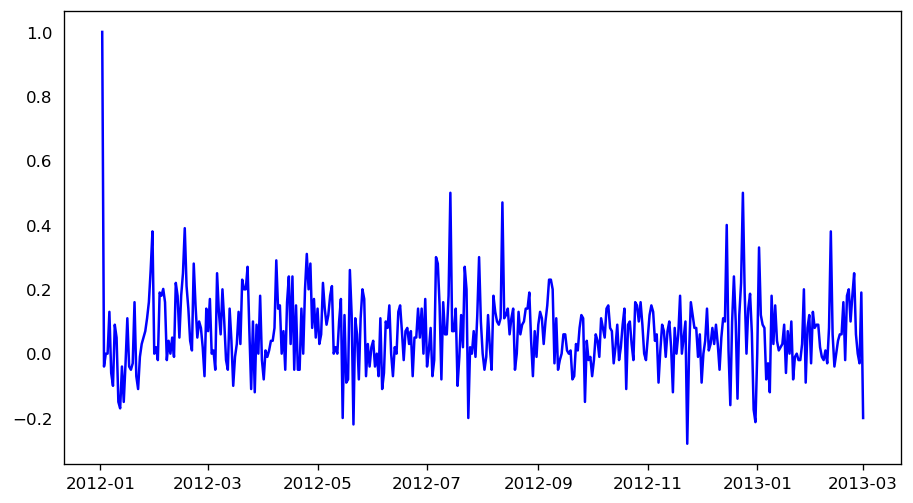

In [405]:
plt.plot(averageScoresPd, color='blue', label='Dataset')
plt.plot(range(len(averageScoresPd), len(averageScoresPd) + len(foreW)), foreW, color='red', label='One Week Prediction')
plt.plot(range(len(averageScoresPd), len(averageScoresPd) + len(foreM)), foreM, color='green', label='One Month Prediction')
plt.plot(range(len(averageScoresPd), len(averageScoresPd) + len(foreMs)), foreMs, color='orange', label='Three Months Prediction')
plt.legend()
plt.show()

TypeError: object of type 'numpy.float64' has no len()

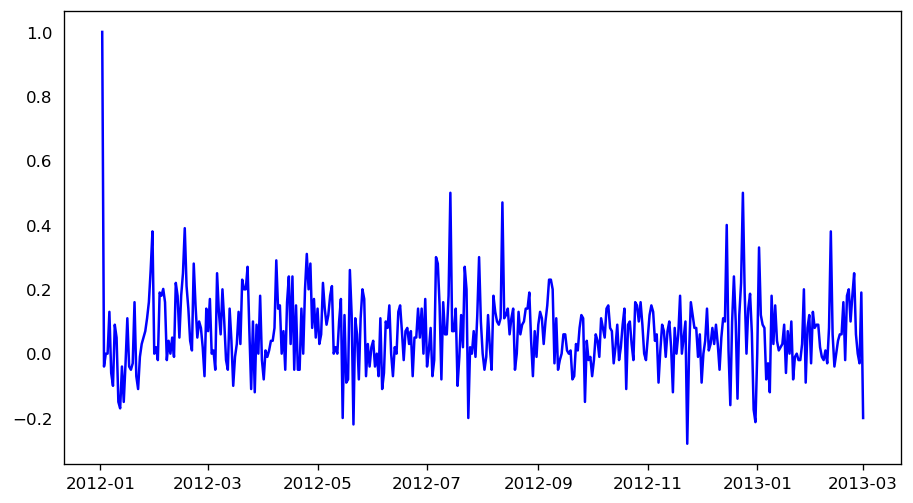

In [390]:
import matplotlib.pyplot as plt

# Fit model
model = ARIMA(averageScoresPd, order=(0, 0, 1))
model_fit = model.fit()

# Make predictions
forecast_one_week = model_fit.forecast(steps=7)[0]
forecast_one_month = model_fit.forecast(steps=30)[0]
forecast_three_months = model_fit.forecast(steps=90)[0]

# Plot dataset and predictions
plt.plot(averageScoresPd, color='blue', label='Dataset')
plt.plot(range(len(averageScoresPd), len(averageScoresPd) + len(forecast_one_week)), forecast_one_week, color='red', label='One Week Prediction')
plt.plot(range(len(averageScoresPd), len(averageScoresPd) + len(forecast_one_month)), forecast_one_month, color='green', label='One Month Prediction')
plt.plot(range(len(averageScoresPd), len(averageScoresPd) + len(forecast_three_months)), forecast_three_months, color='orange', label='Three Months Prediction')
plt.legend()
plt.show()


#### estimating forecastability

In [117]:
averageScoresPd.iloc[:]

date
2012-01-02    1.00
2012-01-03   -0.04
2012-01-04    0.00
2012-01-05   -0.00
2012-01-06    0.13
              ... 
2013-02-25    0.06
2013-02-26    0.00
2013-02-27   -0.03
2013-02-28    0.19
2013-03-01   -0.20
Name: averageScore, Length: 425, dtype: float64

In [118]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(averageScoresPd.iloc[:], m=2, r=0.2*np.std(averageScoresPd.iloc[:])))     
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

TypeError: Invalid argument, not a string or column: [0.0, 0.0, 0.0] of type <class 'list'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [ ]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(averageScoresPd, m=2, r=0.2*np.std(averageScoresPd)))
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

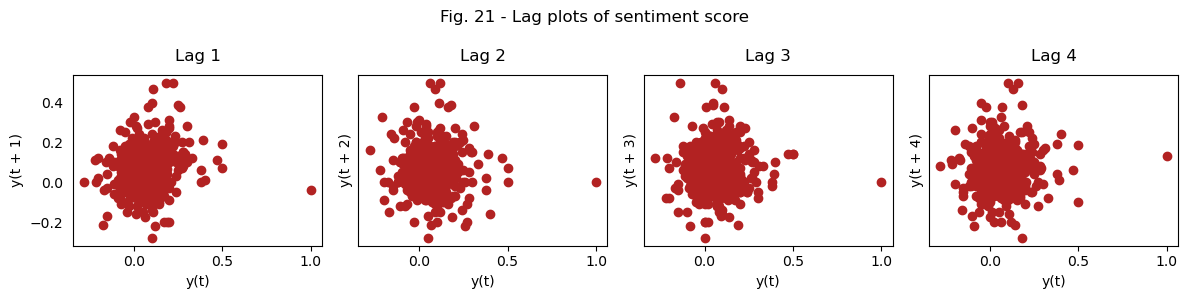

In [355]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True, dpi=100)

for i, ax in enumerate(axes):
    lag_plot(averageScoresPd, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Fig. 21 - Lag plots of sentiment score')

plt.tight_layout()
plt.show()

In [ ]:
averageScoresPd.index['month']

#### Granger casuality

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df['month'] = df.date.dt.month
grangercausalitytests(df[['value', 'month']], maxlag=2)

In [ ]:
averageScoresPd.index.month

In [ ]:
df.date.dt.month

In [ ]:
df[['value', 'month']]

In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)